# Did I Just Find an Exoplanet? 

## Introduction 
You’re an astronomer studying a distant star. Over many nights, you measured how bright the star looks over time.
Sometimes planets pass in front of their stars and block a tiny bit of light — a transit. But the measurements are noisy. You want to know:

    Is there really a planet, or is this just random noise?

You’ll explore this question using simple simulations. 

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
rng = np.random.default_rng(42)

# Utility for clean plots
def hist_with_threshold(samples, threshold, title="", xlabel="counts"):
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.hist(samples, bins=range(int(min(samples)), int(max(samples))+2), alpha=0.8)
    ax.axvline(threshold, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("frequency")
    fig.show()

    return fig, ax


## Simulating a Noisy Light curve

We’ll start by creating a star with constant brightness, but with noise in our measurements.

In [3]:
def generate_lightcurve(n_points=200, noise_level=0.001, transit_depth=0.0):
    """
    Generate a light curve with a transit with a fixed width and a depth 
    that can be adjusted by the user. 

    Parameters
    ----------
    n_points : int, default 200
        The number of points in the light curve

    noise_level : float, default 0.001
        The standard deviation of the Gaussian noise 
        in the data

    transit_depth : flloat, default 0.0
        The depth of the transit. By default, there 
        is no transit in the data.

    Returns
    -------
    time, flux : numpy.ndarray, numpy.ndarray
        The arrays of time and flux of the light curve
        with noise and the transient
    """
    # generate time array
    time = np.linspace(0, 10, n_points)

    # set baseline flux to 1
    flux = np.ones_like(time)

    # transit mid-point in the middle of the light curve
    mid = n_points // 2
    # transit width fixed to a 20th of the length of the light curve
    width = n_points // 20

    # remove flux where planet passes in front of star
    flux[mid - width: mid + width] -= transit_depth
    # Add Gaussian noise with standard deviation set by noise_level
    flux += rng.normal(0, noise_level, size=n_points)
    return time, flux

** functions to learn: 
- `rng = np.random.default_rng(42)`

In [9]:
test = np.random.default_rng(10)
test

Generator(PCG64) at 0x120ED3CA0

Let's generate an example. If you pass in no parameters, there will be *no transit* in the data, because the transit depth is set to 0 by default:

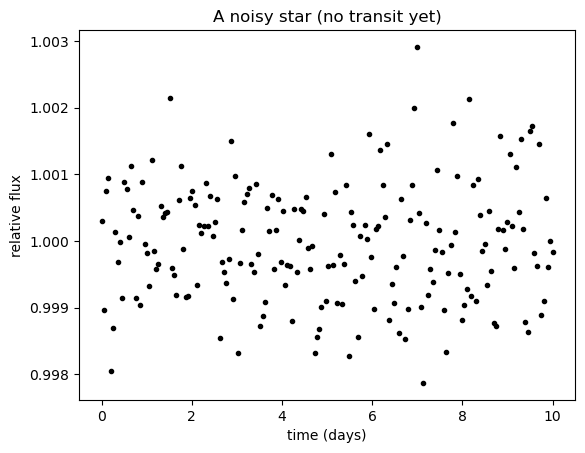

In [4]:
time, flux = generate_lightcurve()
plt.plot(time, flux, 'k.')
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.title("A noisy star (no transit yet)")
plt.show()

**Reflection**: Look at the plot. 
* What kind of random variation do you see?
* Could you mistake a small dip for a planet? Why or why not?

Reflection Answer:

- *it does look like it tends toward lower values (maybe not evenly distributed around 1?)*
Question: 
- how does the random number generator function work with the seed? 
- what is the range of the noise level? is it < 1? 

## Add a Transit and Compare (Interactive Exploration)

Let's add a transit and compare the figures. We'll make it interactive so that you can see how the transit depth and the noise level interact:

In [10]:
@interact(
    transit_depth=FloatSlider(value=0.001, min=0, max=0.01, step=0.0005, description="transit depth", readout_format='.3f'),
    noise_level=FloatSlider(value=0.001, min=0.0001, max=0.005, step=0.0001, description="noise level", readout_format='.4f')
)
def show_transit(transit_depth, noise_level):
    time, flux = generate_lightcurve(noise_level=noise_level, transit_depth=transit_depth)
    plt.plot(time, flux, 'k.')
    plt.xlabel("time (days)")
    plt.ylabel("relative flux")
    plt.title(f"Simulated light curve (depth={transit_depth:.3f})")
    plt.show()

interactive(children=(FloatSlider(value=0.001, description='transit depth', max=0.01, readout_format='.3f', st…

### Going over it after first run: 
- if noise very high, and transit depth kind of shallow, then hard to see actual features
- one thing we can do is say well: how many dips do i expect if there are NO dips in data -- that's what happens in next plot

**Discuss with a partner**: 
* Try increasing the noise — when does the dip become impossible to see?
    - maybe around 1/2 ?? depth 
* Try decreasing the noise — when is the dip obvious?
* What could we do to be more confident there’s a planet?

## What Does “Significant” Mean? 
Say you collect many light curves with no planet at all.
Sometimes noise creates fake dips. How often does that happen?
 1. At least with some Gaussian dist
**Question**:

Without looking ahead, what kind of quantity could we calculate that encapsulates how deep the transit is?
 1. minimum - average?? 

In [17]:
def measure_dip_strength(flux):
    """
    Measure the dip strength by taking the mean inside and outside of the dip.

    Parameters
    ----------
    flux : numpy.ndarray
        The array of flux values

    Returns
    -------
    stat : float
        The dip strength statistic
    """
    n = len(flux)
    ## NOTE: assumes that width and position of dip is fixed!
    mid = n // 2
    width = n // 20
    # find the data points outside of the dip
    outside = np.r_[flux[:mid - width], flux[mid + width:]]
    # find the data points inside the dip
    inside = flux[mid - width: mid + width]
    # calculate mean of both and the difference of means
    stat = outside.mean() - inside.mean()
    return stat


What's the dip strength of a single light curve? What happens when you simulate *many*?

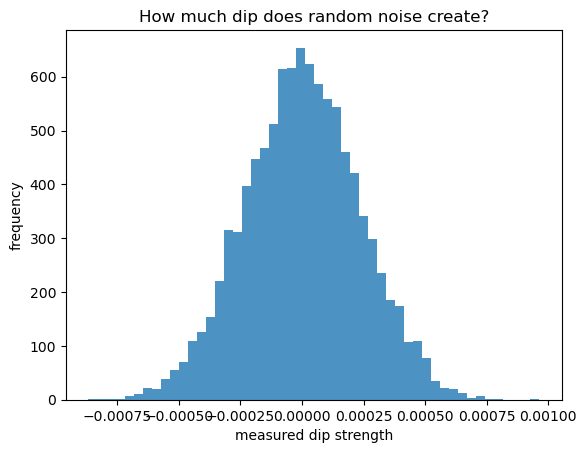

In [18]:
# Simulate many noise-only light curves
n_sim = 10000
dips_noise = [measure_dip_strength(generate_lightcurve(transit_depth=0.0)[1]) for _ in range(n_sim)]

plt.hist(dips_noise, bins=50, alpha=0.8)
plt.xlabel("measured dip strength")
plt.ylabel("frequency")
plt.title("How much dip does random noise create?")
plt.show()

### going over after
- if dip strength is SURPRISING, given the underlying Gaussian, then it might be significant. 

**Reflection**:
* Even without a planet, sometimes we see “big dips.”
* How big would a dip need to be before you start suspecting a real planet? sketch a cut-off line in the plot above.

## Simulating Planets

Now add real transits of varying strength, and see how often we’d “detect” them using our chosen threshold.
For this, you have to define a *false alarm rate*: how often you're happy to accept a false detection (due to noise). A false alarm rate of 5% means that out of a 100 light curves, you'd expect 5 to show up as a "planet transit" given our definition above, even if *none* of the light curves contain an actual exoplanet transit.

There are 95 detections out of 2000 light curves for a dip depth of 0.0
There are 230 detections out of 2000 light curves for a dip depth of 0.0001
There are 1422 detections out of 2000 light curves for a dip depth of 0.0005
There are 1991 detections out of 2000 light curves for a dip depth of 0.001
There are 2000 detections out of 2000 light curves for a dip depth of 0.005


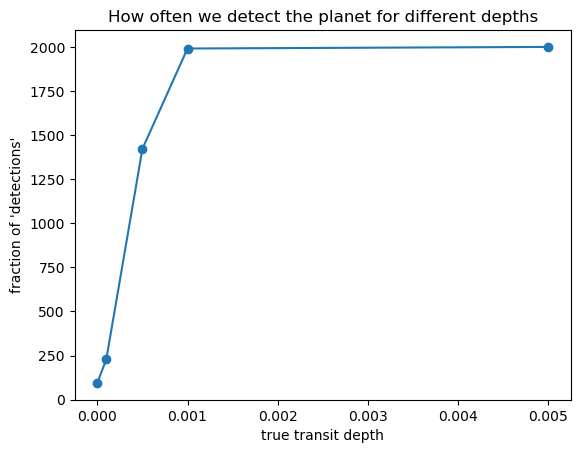

In [19]:
# define false alarm rate
fa_rate =  0.05   # add a number here, between 0 and 1, 0.05 translates to 5%

# the treshold for detection is calculated using the 1-fa_rate percentile
# np.percentile uses actual percent, so we have to multiply by 100
threshold = np.percentile(dips_noise, 100 - fa_rate*100)  

# Simulate real planets
# ADJUST THE DEPTHS TO YOUR LIKING!
depths = [0.0, 0.0001, 0.0005, 0.001, 0.005]

n_sim = 2000
results = []

for d in depths:
    dips = [measure_dip_strength(generate_lightcurve(transit_depth=d)[1]) for _ in range(n_sim)]
    detections = np.sum(np.array(dips) > threshold)
    print(f"There are {detections} detections out of {n_sim} light curves for a dip depth of {d}")
    results.append(detections)

plt.plot(depths, results, 'o-')
plt.xlabel("true transit depth")
plt.ylabel("fraction of 'detections'")
plt.title("How often we detect the planet for different depths")
plt.show()

### going over after
- if dip strength low, often miss (too similar to noise)
- if noise level very high, transit depth low, distribution of dip strength with and without dip basically overlap

**Reflection**:
* For no planet (depth = 0), there are nevertheless "detections": these are false alarms or *false positives*.
* For small planets, we often miss them: these are missed detections (*false negatives*)
* Discuss with a partner: if you set your detection threshold to be *really* small, what effect do you think that have on your chance of seeing false positive detections? How likely are you to miss real signals? In a realistic detection scenario, can you think of reasons to trade off one versus the other? 
    - if really small, you probably lessen false positives but also more likely to miss real signals because the threshold is more strict
    - i think in reality, might be better to prioritize getting more data and cleaning later? 


## Exploring the Trade-Offs

In [ ]:

@interact(
    alpha=FloatSlider(value=0.05, min=0.0001, max=0.3, step=0.0001, description="tolerance for false alarms (α)", readout_format='.4f'),
    noise_level=FloatSlider(value=0.001, min=0.0001, max=0.005, step=0.0002, description="noise level", readout_format='.4f'),
    transit_depth=FloatSlider(value=0.001, min=0.0001, max=0.005, step=0.0001, description="transit depth", readout_format=".4f")
)
def explore_tradeoff(alpha, noise_level, transit_depth):
    dips_noise = [measure_dip_strength(generate_lightcurve(noise_level=noise_level)[1]) for _ in range(5000)]
    threshold = np.quantile(dips_noise, 1 - alpha)
    dips_planet = [measure_dip_strength(generate_lightcurve(noise_level=noise_level, transit_depth=transit_depth)[1]) for _ in range(2000)]
    detected = np.mean(np.array(dips_planet) > threshold)

    plt.hist(dips_noise, bins=50, alpha=0.7, label="no planet")
    plt.hist(dips_planet, bins=50, alpha=0.7, label="planet")
    plt.axvline(threshold, color="k", linestyle="--", label="decision threshold")
    plt.xlabel("measured dip strength")
    plt.ylabel("frequency")
    plt.legend()
    plt.title(f"α={alpha:.3f}, detection rate≈{detected:.2f}")
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='tolerance for false alarms (α)', max=0.3, min=0.000…

**Reflection**:
* Make the detection threshold ($\alpha$) very small. What happens to false alarms? To missed planets?
* Increase the noise. How does the overlap change?
* Similarly, change the transit depth. How do transit depth and noise level *together* affect the detection probability
* What could you do in an actual observing campaign to improve the detection rate?

**Advanced question**:
A planet detection survey has observed 200 stars. They want to be *very* confident that any planet they find is real. 
* Imagine they set their detection threshold to 0.01. How many false positive detections are they expected to get, on average. Is their threshold low enough to avoid false positives with high probability?
* Where would they need to set their threshold in order to ensure that *across* their whole sample of 200 stars, the probability of obtaining a detection when there is only noise is 0.01?
